In [50]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, RMSprop
from keras.layers import BatchNormalization
from keras.layers import Dropout

from sklearn.decomposition import PCA
from modules.pca_module import perform_pca
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE


### 1-Load data

In [51]:
knn_df = pd.read_csv('clean_data/KNN_imputed_df.csv')
m1_df = pd.read_csv('clean_data/minus1_imputed_df.csv')

In [52]:
pd.options.display.max_columns = None
knn_df.sample()

,RecordID,Age,Gender,ICUType,BMI,MechVent,BUN_median,BUN_mad,BUN_slope,Creatinine_median,Creatinine_mad,FiO2_median,FiO2_max,FiO2_mad,GCS_median,GCS_mad,Glucose_48median,Glucose_median,Glucose_max,Glucose_mad,Glucose_slope,HCO3_median,HCO3_mad,HCT_median,HCT_mad,HR_median,HR_max,HR_mad,HR_slope,K_48median,K_median,K_max,K_mad,Lactate_median,Lactate_mad,Mg_median,Mg_max,Mg_mad,MAP_median,MAP_max,MAP_mad,MAP_last,MAP_slope,Na_median,Na_mad,Na_slope,NIMAP_median,NIMAP_max,NIMAP_mad,NIMAP_last,NIMAP_slope,PaCO2_median,PaCO2_mad,PaCO2_slope,PaO2_48median,PaO2_median,PaO2_max,PaO2_mad,PaO2_slope,pH_median,pH_mad,Platelets_median,Platelets_mad,Platelets_slope,Temp_48median,Temp_median,Temp_max,Temp_mad,Temp_last,Urine_median,Urine_max,Urine_mad,Urine_last,Urine_slope,WBC_median,WBC_mad,WBC_slope,Weight_24median,Weight_mad,Length_of_stay,In-hospital_death
5056,145325.0,52.0,0,4,23.681271,1,9.5,15.789474,-0.125,0.65,7.692308,0.529863,0.6655,5.057492,15.0,0.0,114.0,113.5,114.0,0.440529,0.041667,25.5,1.960784,39.95,1.376721,59.0,76.0,5.084746,0.010503,3.8,3.55,3.8,7.042254,2.129725,15.076892,1.8,1.9,5.555556,82.29,107.255,7.49091,84.4725,-0.0622,142.0,0.704225,0.083333,86.67,99.67,7.68432,84.33,0.064433,40.21625,6.414208,-0.050759,119.55875,139.88625,224.265,16.514338,-3.285822,7.397225,0.350886,249.0,0.803213,0.166667,36.45,36.8,37.4,1.086957,35.8,650.0,1000.0,42.307692,300.0,3.258633,8.0,5.0,0.033333,68.6,0.0,5,0


In [53]:
knn_df.shape , m1_df.shape

((8000, 81), (8000, 81))

### 2-Look at the distribution target("type") variable
As both df are the same and its difference is the NaN imputation, the outcomes distribution will be the same

In [54]:
knn_df['In-hospital_death'].value_counts()

In-hospital_death
0    6878
1    1122
Name: count, dtype: int64

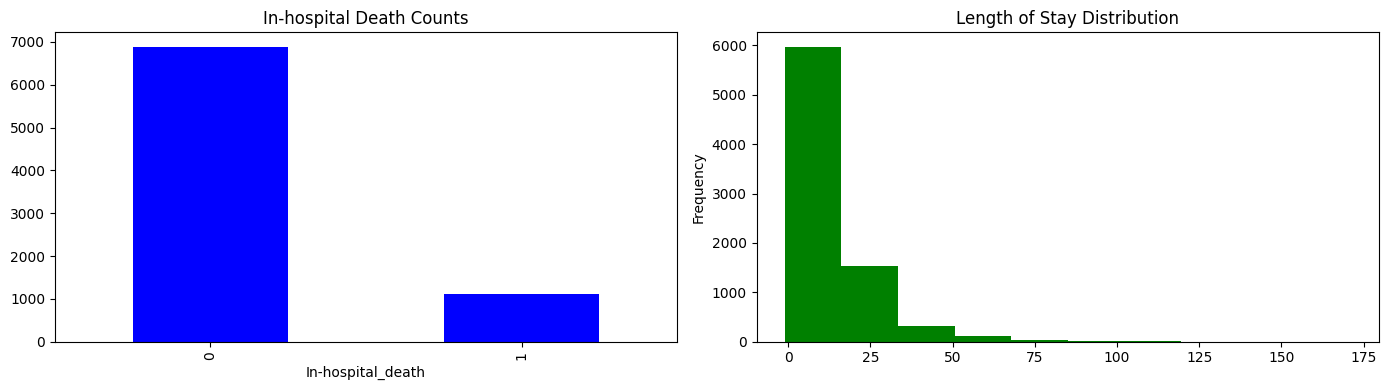

In [55]:
import matplotlib.pyplot as plt

# Create a new figure and axis objects
fig, axs = plt.subplots(1, 2, figsize=(14, 4))  # 1 row, 2 columns for two plots

# Plot the count of each value in the 'In-hospital_death' column as a bar plot
knn_df['In-hospital_death'].value_counts().plot(kind="bar", ax=axs[0], color='blue')

# Plot the distribution of values in the 'Length_of_stay' column as a histogram
knn_df['Length_of_stay'].plot(kind="hist", ax=axs[1], color='green')

# Set titles for each subplot
axs[0].set_title('In-hospital Death Counts')
axs[1].set_title('Length of Stay Distribution')

# Show the plots
plt.tight_layout()
plt.show()


### 3-IN_HOSPITAL_DEATH PREDICTION

**3.1 -Create a function that**
 - remove the outcome columns and palaces RecordID as index
 - splits the data
 - normalizes the data
 - creates / compiles and trains a basic model
 - predicts the outcomes


*FUNCTION PARAMETERS*
- Input layer - 64 nodes, activation ReLu, input features

- Hidden layer - 64 nodes activation ReLu

- Output - 1 node, activation sigmoid

*Optimization and cost for the model*
- loss - "mse" # Mean Squared Error

- optimizer - SGD # Stochastic Gradient Descent

- metrics - "mae" # Mean average error  

In order to keep all the results we will save them to finally summarize in a df

In [56]:
# Create a df to save the results
data = {
    "Method": [],
    "mean_precision": [],
    "mean_recall": [],
    "stdev_precision": [],
    "stdev_recall": []
}

df_results = pd.DataFrame(data)


In [57]:
knn_df.sample()

,RecordID,Age,Gender,ICUType,BMI,MechVent,BUN_median,BUN_mad,BUN_slope,Creatinine_median,Creatinine_mad,FiO2_median,FiO2_max,FiO2_mad,GCS_median,GCS_mad,Glucose_48median,Glucose_median,Glucose_max,Glucose_mad,Glucose_slope,HCO3_median,HCO3_mad,HCT_median,HCT_mad,HR_median,HR_max,HR_mad,HR_slope,K_48median,K_median,K_max,K_mad,Lactate_median,Lactate_mad,Mg_median,Mg_max,Mg_mad,MAP_median,MAP_max,MAP_mad,MAP_last,MAP_slope,Na_median,Na_mad,Na_slope,NIMAP_median,NIMAP_max,NIMAP_mad,NIMAP_last,NIMAP_slope,PaCO2_median,PaCO2_mad,PaCO2_slope,PaO2_48median,PaO2_median,PaO2_max,PaO2_mad,PaO2_slope,pH_median,pH_mad,Platelets_median,Platelets_mad,Platelets_slope,Temp_48median,Temp_median,Temp_max,Temp_mad,Temp_last,Urine_median,Urine_max,Urine_mad,Urine_last,Urine_slope,WBC_median,WBC_mad,WBC_slope,Weight_24median,Weight_mad,Length_of_stay,In-hospital_death
3987,142649.0,75.0,1,3,57.927161,1,24.0,16.666667,-0.264925,1.2,8.333333,0.5158,0.674,4.747549,15.0,0.0,109.0,113.0,121.0,3.539823,-0.19403,21.0,0.0,28.4,2.112676,81.75,110.0,6.727829,0.097844,3.4,3.8,3.8,0.0,2.148625,12.568888,1.9,2.0,5.263158,80.82875,106.4825,7.901736,81.04,0.043403,149.0,0.0,-0.067164,81.165,107.3,9.037147,76.67,-0.17484,39.86375,5.70322,-0.012656,113.4675,134.15625,242.915,19.401857,-3.463386,7.38545,0.33637,113.0,1.769912,0.320896,37.1,36.85,38.1,0.407056,37.3,120.0,250.0,16.666667,35.0,-2.084997,6.6,3.030303,0.014925,80.7,0.0,6,0


In [58]:
def NN_basic_model(df):
    """
    Builds and trains a basic neural network model for binary classification.

    Args:
        df (pd.DataFrame): Input DataFrame containing features and target variable.

    Returns:
        float: F1-score on the test set.
    """
    # Extract features and target variable
    X = df.drop(columns=['In-hospital_death', 'Length_of_stay', 'RecordID'])
    y = df['In-hospital_death']

    # Data splitting
    test_size = 0.2
    random_state = 42
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Data normalization
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Model architecture with BatchNormalization and Dropout
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))  # Add dropout layer
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer and compilation
    sgd = SGD(learning_rate=0.1)
    model.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy"])

    # Model training
    epochs = 20
    batch_size = 32
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    # Getting predictions
    y_pred = model.predict(X_test)
    y_pred_binary = np.where(y_pred > 0.5, 1, 0)

    # Calculate metrics
 
    precision = precision_score(y_test, y_pred_binary)
    print(f"precision on test set: {precision:.2f}")
    recall = recall_score(y_test, y_pred_binary)
    print(f"recall on test set: {recall:.2f}")

    return y_test, y_pred_binary

**3.2- Evaluation of the model performance on the two loaded dataframes**

in order to have more information we will run each model 10 times

In [59]:
def run_function_10_times(df, function):
        precision = []
        recall = []
        for i in range(10):   
                y_test, y_pred = function(knn_df)
                prec= precision_score(y_test, y_pred)
                rec = recall_score(y_test, y_pred)
                precision.append(prec)
                recall.append(rec)
        return np.mean(precision), np.mean(recall), np.std(precision), np.std(recall)

In [60]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(knn_df,NN_basic_model)

Epoch 1/20
200/200 [==============================] - 1s 1ms/step - loss: 0.3654 - accuracy: 0.8605
Epoch 2/20
200/200 [==============================] - 0s 1ms/step - loss: 0.3212 - accuracy: 0.8706
Epoch 3/20
200/200 [==============================] - 0s 1ms/step - loss: 0.3019 - accuracy: 0.8775
Epoch 4/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2937 - accuracy: 0.8778
Epoch 5/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2809 - accuracy: 0.8855
Epoch 6/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2768 - accuracy: 0.8838
Epoch 7/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2698 - accuracy: 0.8856
Epoch 8/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2609 - accuracy: 0.8908
Epoch 9/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2587 - accuracy: 0.8922
Epoch 10/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2444 - accuracy: 0.8983

In [61]:
print(f"basic_NN for Knn_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
method_name = "knn_df"
df_results.loc[0] = [method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]

basic_NN for Knn_df : mean_prec = 0.4610863027796939, mean_rec =  0.363063063063063, stdev_prec = 0.03744119909947685, stdev_recall = 0.05168219642977825


In [62]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(m1_df,NN_basic_model)

Epoch 1/20
200/200 [==============================] - 1s 1ms/step - loss: 0.3670 - accuracy: 0.8597
Epoch 2/20
200/200 [==============================] - 0s 1ms/step - loss: 0.3177 - accuracy: 0.8694
Epoch 3/20
200/200 [==============================] - 0s 1ms/step - loss: 0.3050 - accuracy: 0.8761
Epoch 4/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2936 - accuracy: 0.8759
Epoch 5/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2821 - accuracy: 0.8831
Epoch 6/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2772 - accuracy: 0.8844
Epoch 7/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2669 - accuracy: 0.8911
Epoch 8/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2617 - accuracy: 0.8916
Epoch 9/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2571 - accuracy: 0.8917
Epoch 10/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2426 - accuracy: 0.8966

In [63]:
print(f"basic_NN for m1_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
method_name = "m1_df"
df_results.loc[1] = [method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]

basic_NN for m1_df : mean_prec = 0.4690303648900742, mean_rec =  0.3554054054054054, stdev_prec = 0.03235168716935822, stdev_recall = 0.04246914117658374


**3.3 -Use PCA in the models to check for improvement.**

As PCA already requieres standarization of numerica features a new function must be created but the model will be the same. 

In [64]:
def NN_PCA_model(df):
    """
    Builds and trains an improved neural network model for binary classification using PCA.

    Args:
        Data frame.

    Returns:
        Predicted value and real test value.
    """
        # Extract features and target variable
    X = df.drop(columns=['In-hospital_death', 'Length_of_stay'])
    y = df['In-hospital_death']

    # Data splitting
    test_size = 0.2
    random_state = 42
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    #exclude categorical features from PCA transformation
    categorical_features = ['Gender', 'ICUType', 'MechVent']
    X_train, X_test, pca, explained_variance_ratio = perform_pca(train_data = X_train, test_data = X_test, n_components=0.95, categorical_features=categorical_features)

    # Model architecture with BatchNormalization and Dropout
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))  # Add dropout layer
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer and compilation
    sgd = SGD(learning_rate=0.1)
    model.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy"])

    # Model training
    epochs = 20
    batch_size = 32
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    # Getting predictions
    y_pred = model.predict(X_test)
    y_pred_binary = np.where(y_pred > 0.5, 1, 0)

    # Calculate metrics
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    print(f"Precision on test set: {precision:.2f}")
    print(f"Recall on test set: {recall:.2f}")

    return y_test, y_pred_binary



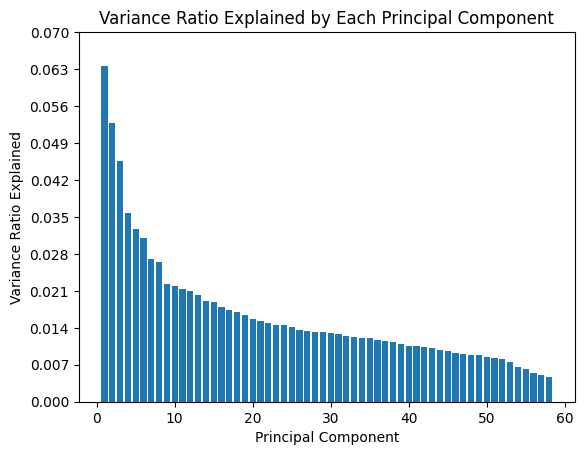

Number of components required to achieve 0.95 variance explained: 58
Epoch 1/20
200/200 [==============================] - 1s 1ms/step - loss: 0.3654 - accuracy: 0.8559
Epoch 2/20
200/200 [==============================] - 0s 1ms/step - loss: 0.3230 - accuracy: 0.8706
Epoch 3/20
200/200 [==============================] - 0s 1ms/step - loss: 0.3004 - accuracy: 0.8750
Epoch 4/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2920 - accuracy: 0.8773
Epoch 5/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2871 - accuracy: 0.8834
Epoch 6/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2790 - accuracy: 0.8853
Epoch 7/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2746 - accuracy: 0.8828
Epoch 8/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2700 - accuracy: 0.8856
Epoch 9/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2574 - accuracy: 0.8914
Epoch 10/20
200/200 [==========

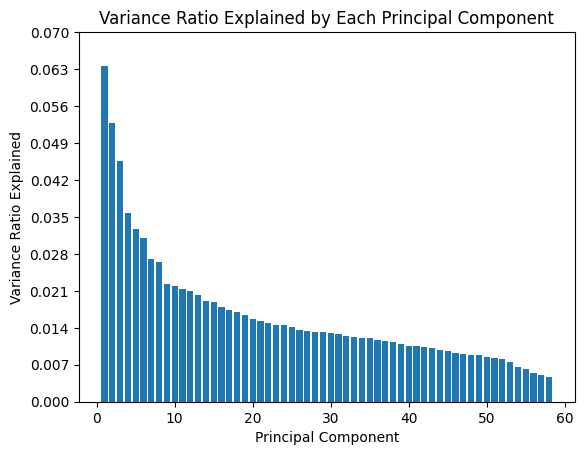

Number of components required to achieve 0.95 variance explained: 58
Epoch 1/20
200/200 [==============================] - 1s 2ms/step - loss: 0.3729 - accuracy: 0.8573
Epoch 2/20
200/200 [==============================] - 0s 2ms/step - loss: 0.3280 - accuracy: 0.8669
Epoch 3/20
200/200 [==============================] - 0s 2ms/step - loss: 0.3098 - accuracy: 0.8747
Epoch 4/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2988 - accuracy: 0.8784
Epoch 5/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2894 - accuracy: 0.8802
Epoch 6/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2769 - accuracy: 0.8803
Epoch 7/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2758 - accuracy: 0.8844
Epoch 8/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2740 - accuracy: 0.8823
Epoch 9/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2603 - accuracy: 0.8898
Epoch 10/20
200/200 [==========

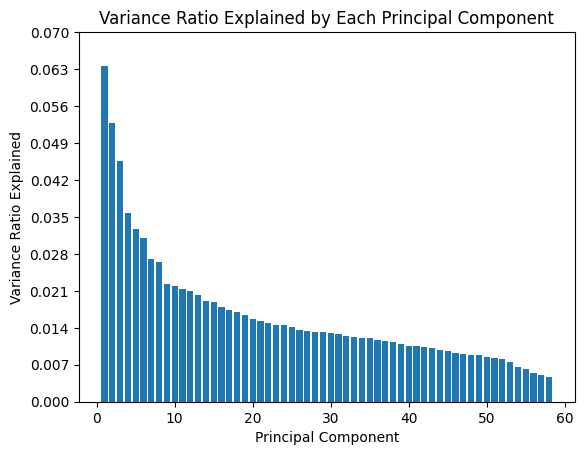

Number of components required to achieve 0.95 variance explained: 58
Epoch 1/20
200/200 [==============================] - 1s 1ms/step - loss: 0.3751 - accuracy: 0.8547
Epoch 2/20
200/200 [==============================] - 0s 1ms/step - loss: 0.3267 - accuracy: 0.8655
Epoch 3/20
200/200 [==============================] - 0s 1ms/step - loss: 0.3104 - accuracy: 0.8733
Epoch 4/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2950 - accuracy: 0.8759
Epoch 5/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2905 - accuracy: 0.8780
Epoch 6/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2760 - accuracy: 0.8858
Epoch 7/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2767 - accuracy: 0.8867
Epoch 8/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2691 - accuracy: 0.8850
Epoch 9/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2625 - accuracy: 0.8900
Epoch 10/20
200/200 [==========

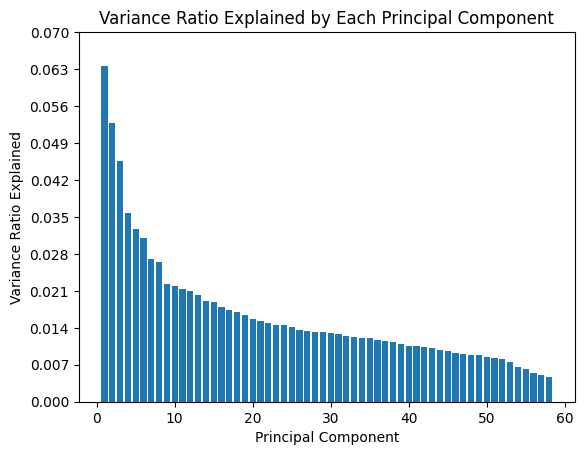

Number of components required to achieve 0.95 variance explained: 58
Epoch 1/20
200/200 [==============================] - 1s 1ms/step - loss: 0.3738 - accuracy: 0.8517
Epoch 2/20
200/200 [==============================] - 0s 2ms/step - loss: 0.3276 - accuracy: 0.8677
Epoch 3/20
200/200 [==============================] - 0s 2ms/step - loss: 0.3128 - accuracy: 0.8733
Epoch 4/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2938 - accuracy: 0.8775
Epoch 5/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2915 - accuracy: 0.8739
Epoch 6/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2839 - accuracy: 0.8811
Epoch 7/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2821 - accuracy: 0.8798
Epoch 8/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2747 - accuracy: 0.8866
Epoch 9/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2664 - accuracy: 0.8869
Epoch 10/20
200/200 [==========

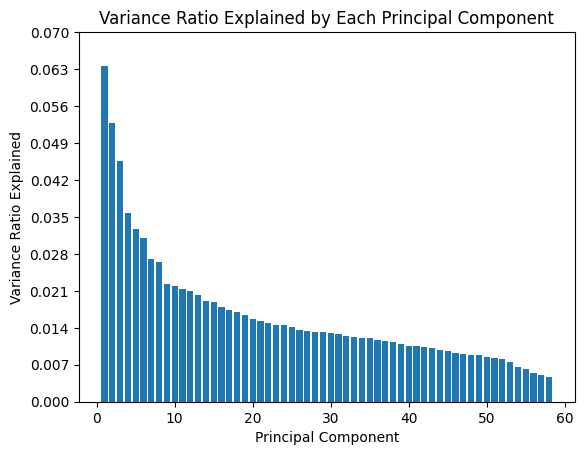

Number of components required to achieve 0.95 variance explained: 58
Epoch 1/20
200/200 [==============================] - 1s 2ms/step - loss: 0.3754 - accuracy: 0.8572
Epoch 2/20
200/200 [==============================] - 0s 1ms/step - loss: 0.3230 - accuracy: 0.8678
Epoch 3/20
200/200 [==============================] - 1s 3ms/step - loss: 0.3118 - accuracy: 0.8698
Epoch 4/20
200/200 [==============================] - 0s 2ms/step - loss: 0.3071 - accuracy: 0.8691
Epoch 5/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2910 - accuracy: 0.8784
Epoch 6/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2841 - accuracy: 0.8781
Epoch 7/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2847 - accuracy: 0.8770
Epoch 8/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2715 - accuracy: 0.8855
Epoch 9/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2693 - accuracy: 0.8853
Epoch 10/20
200/200 [==========

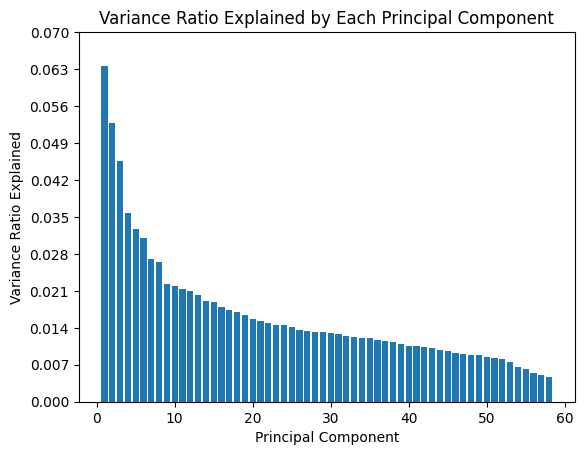

Number of components required to achieve 0.95 variance explained: 58
Epoch 1/20
200/200 [==============================] - 1s 1ms/step - loss: 0.3854 - accuracy: 0.8530
Epoch 2/20
200/200 [==============================] - 0s 1ms/step - loss: 0.3241 - accuracy: 0.8675
Epoch 3/20
200/200 [==============================] - 0s 1ms/step - loss: 0.3106 - accuracy: 0.8756
Epoch 4/20
200/200 [==============================] - 0s 2ms/step - loss: 0.3034 - accuracy: 0.8720
Epoch 5/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2913 - accuracy: 0.8780
Epoch 6/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2864 - accuracy: 0.8798
Epoch 7/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2744 - accuracy: 0.8852
Epoch 8/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2745 - accuracy: 0.8838
Epoch 9/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2668 - accuracy: 0.8898
Epoch 10/20
200/200 [==========

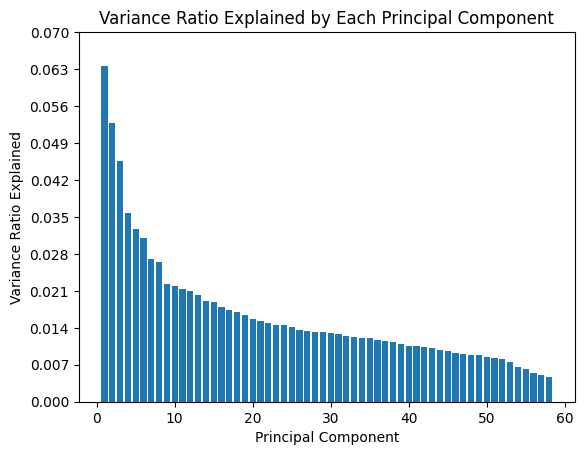

Number of components required to achieve 0.95 variance explained: 58
Epoch 1/20
200/200 [==============================] - 1s 1ms/step - loss: 0.3743 - accuracy: 0.8553
Epoch 2/20
200/200 [==============================] - 0s 2ms/step - loss: 0.3297 - accuracy: 0.8655
Epoch 3/20
200/200 [==============================] - 0s 2ms/step - loss: 0.3118 - accuracy: 0.8719
Epoch 4/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2983 - accuracy: 0.8766
Epoch 5/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2911 - accuracy: 0.8777
Epoch 6/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2868 - accuracy: 0.8786
Epoch 7/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2782 - accuracy: 0.8839
Epoch 8/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2679 - accuracy: 0.8883
Epoch 9/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2647 - accuracy: 0.8881
Epoch 10/20
200/200 [==========

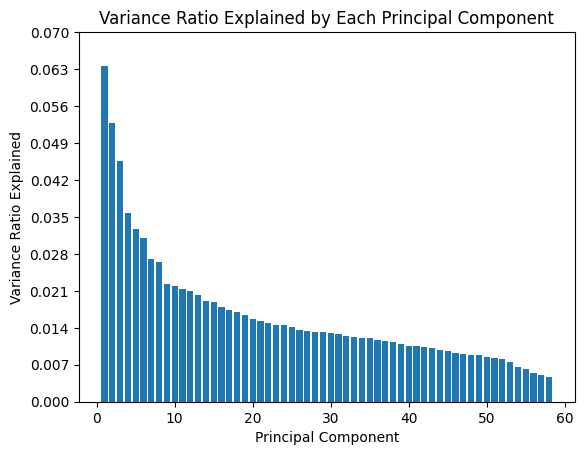

Number of components required to achieve 0.95 variance explained: 58
Epoch 1/20
200/200 [==============================] - 1s 2ms/step - loss: 0.3744 - accuracy: 0.8564
Epoch 2/20
200/200 [==============================] - 0s 1ms/step - loss: 0.3256 - accuracy: 0.8680
Epoch 3/20
200/200 [==============================] - 0s 1ms/step - loss: 0.3107 - accuracy: 0.8678
Epoch 4/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2991 - accuracy: 0.8766
Epoch 5/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2915 - accuracy: 0.8773
Epoch 6/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2840 - accuracy: 0.8808
Epoch 7/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2777 - accuracy: 0.8878
Epoch 8/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2662 - accuracy: 0.8916
Epoch 9/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2652 - accuracy: 0.8892
Epoch 10/20
200/200 [==========

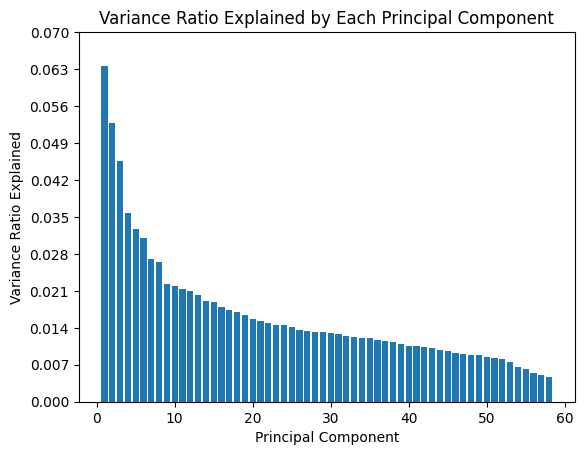

Number of components required to achieve 0.95 variance explained: 58
Epoch 1/20
200/200 [==============================] - 1s 1ms/step - loss: 0.3559 - accuracy: 0.8627
Epoch 2/20
200/200 [==============================] - 0s 1ms/step - loss: 0.3199 - accuracy: 0.8719
Epoch 3/20
200/200 [==============================] - 0s 1ms/step - loss: 0.3091 - accuracy: 0.8723
Epoch 4/20
200/200 [==============================] - 1s 3ms/step - loss: 0.2935 - accuracy: 0.8783
Epoch 5/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2878 - accuracy: 0.8847
Epoch 6/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2827 - accuracy: 0.8786
Epoch 7/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2691 - accuracy: 0.8875
Epoch 8/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2660 - accuracy: 0.8895
Epoch 9/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2649 - accuracy: 0.8936
Epoch 10/20
200/200 [==========

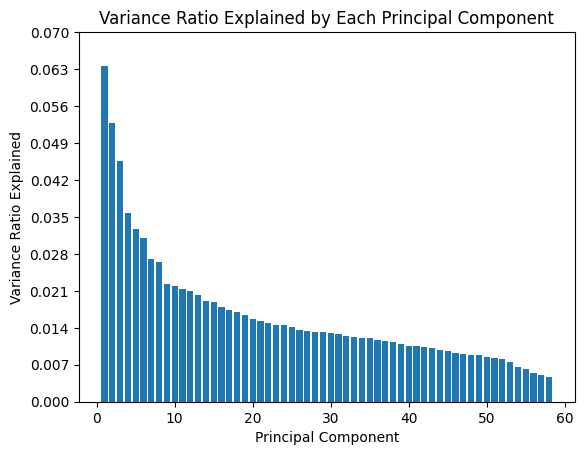

Number of components required to achieve 0.95 variance explained: 58
Epoch 1/20
200/200 [==============================] - 1s 2ms/step - loss: 0.3732 - accuracy: 0.8555
Epoch 2/20
200/200 [==============================] - 0s 1ms/step - loss: 0.3263 - accuracy: 0.8662
Epoch 3/20
200/200 [==============================] - 0s 1ms/step - loss: 0.3119 - accuracy: 0.8714
Epoch 4/20
200/200 [==============================] - 0s 1ms/step - loss: 0.3012 - accuracy: 0.8773
Epoch 5/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2880 - accuracy: 0.8792
Epoch 6/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2890 - accuracy: 0.8797
Epoch 7/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2812 - accuracy: 0.8808
Epoch 8/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2700 - accuracy: 0.8891
Epoch 9/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2712 - accuracy: 0.8913
Epoch 10/20
200/200 [==========

In [65]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(knn_df,NN_PCA_model)

In [66]:
print(f"basic_NN_PCA for knn_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
method_name = "PCA_knn_df"
df_results.loc[2] = [method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]

basic_NN_PCA for knn_df : mean_prec = 0.48028991400906856, mean_rec =  0.32747747747747746, stdev_prec = 0.04373518868697464, stdev_recall = 0.06427566484152887


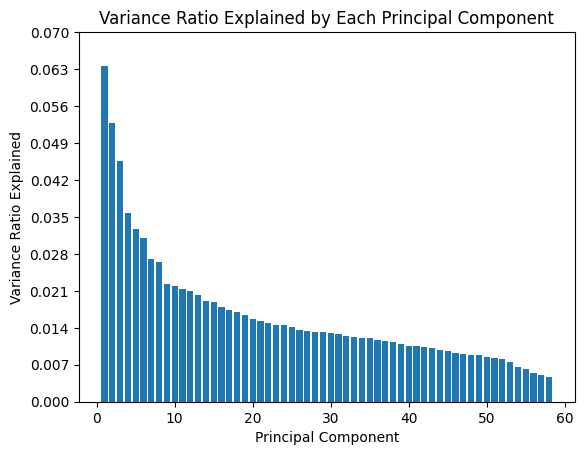

Number of components required to achieve 0.95 variance explained: 58
Epoch 1/20
200/200 [==============================] - 1s 1ms/step - loss: 0.3713 - accuracy: 0.8561
Epoch 2/20
200/200 [==============================] - 0s 1ms/step - loss: 0.3279 - accuracy: 0.8642
Epoch 3/20
200/200 [==============================] - 0s 1ms/step - loss: 0.3104 - accuracy: 0.8720
Epoch 4/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2969 - accuracy: 0.8763
Epoch 5/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2886 - accuracy: 0.8778
Epoch 6/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2836 - accuracy: 0.8809
Epoch 7/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2806 - accuracy: 0.8822
Epoch 8/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2724 - accuracy: 0.8822
Epoch 9/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2650 - accuracy: 0.8875
Epoch 10/20
200/200 [==========

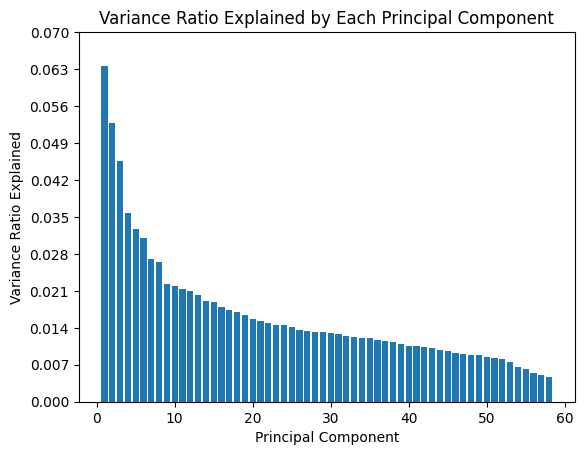

Number of components required to achieve 0.95 variance explained: 58
Epoch 1/20
200/200 [==============================] - 1s 2ms/step - loss: 0.3720 - accuracy: 0.8556
Epoch 2/20
200/200 [==============================] - 0s 2ms/step - loss: 0.3229 - accuracy: 0.8691
Epoch 3/20
200/200 [==============================] - 0s 2ms/step - loss: 0.3086 - accuracy: 0.8730
Epoch 4/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2951 - accuracy: 0.8786
Epoch 5/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2909 - accuracy: 0.8777
Epoch 6/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2809 - accuracy: 0.8831
Epoch 7/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2737 - accuracy: 0.8800
Epoch 8/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2701 - accuracy: 0.8848
Epoch 9/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2620 - accuracy: 0.8864
Epoch 10/20
200/200 [==========

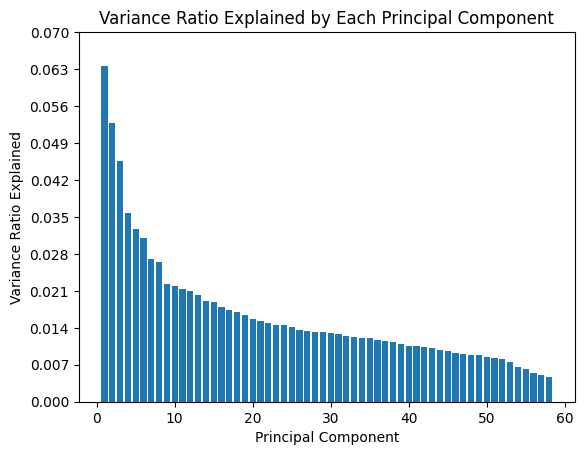

Number of components required to achieve 0.95 variance explained: 58
Epoch 1/20
200/200 [==============================] - 1s 1ms/step - loss: 0.3691 - accuracy: 0.8552
Epoch 2/20
200/200 [==============================] - 0s 1ms/step - loss: 0.3221 - accuracy: 0.8684
Epoch 3/20
200/200 [==============================] - 0s 1ms/step - loss: 0.3093 - accuracy: 0.8736
Epoch 4/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2998 - accuracy: 0.8788
Epoch 5/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2897 - accuracy: 0.8813
Epoch 6/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2833 - accuracy: 0.8808
Epoch 7/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2750 - accuracy: 0.8820
Epoch 8/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2694 - accuracy: 0.8869
Epoch 9/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2634 - accuracy: 0.8892
Epoch 10/20
200/200 [==========

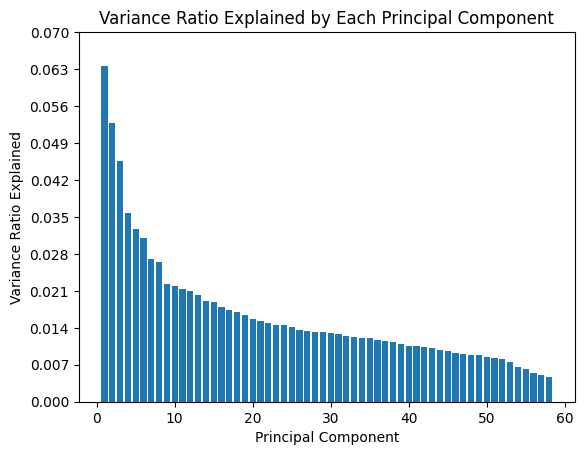

Number of components required to achieve 0.95 variance explained: 58
Epoch 1/20
200/200 [==============================] - 1s 1ms/step - loss: 0.3668 - accuracy: 0.8591
Epoch 2/20
200/200 [==============================] - 0s 1ms/step - loss: 0.3189 - accuracy: 0.8706
Epoch 3/20
200/200 [==============================] - 0s 1ms/step - loss: 0.3110 - accuracy: 0.8702
Epoch 4/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2956 - accuracy: 0.8808
Epoch 5/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2876 - accuracy: 0.8780
Epoch 6/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2861 - accuracy: 0.8811
Epoch 7/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2753 - accuracy: 0.8823
Epoch 8/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2665 - accuracy: 0.8891
Epoch 9/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2649 - accuracy: 0.8878
Epoch 10/20
200/200 [==========

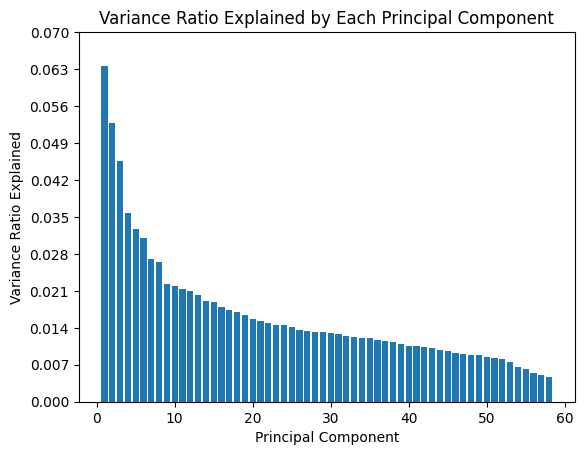

Number of components required to achieve 0.95 variance explained: 58
Epoch 1/20
200/200 [==============================] - 1s 1ms/step - loss: 0.3761 - accuracy: 0.8530
Epoch 2/20
200/200 [==============================] - 0s 1ms/step - loss: 0.3266 - accuracy: 0.8680
Epoch 3/20
200/200 [==============================] - 0s 1ms/step - loss: 0.3152 - accuracy: 0.8716
Epoch 4/20
200/200 [==============================] - 0s 1ms/step - loss: 0.3017 - accuracy: 0.8775
Epoch 5/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2947 - accuracy: 0.8802
Epoch 6/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2863 - accuracy: 0.8813
Epoch 7/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2790 - accuracy: 0.8847
Epoch 8/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2752 - accuracy: 0.8838
Epoch 9/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2659 - accuracy: 0.8888
Epoch 10/20
200/200 [==========

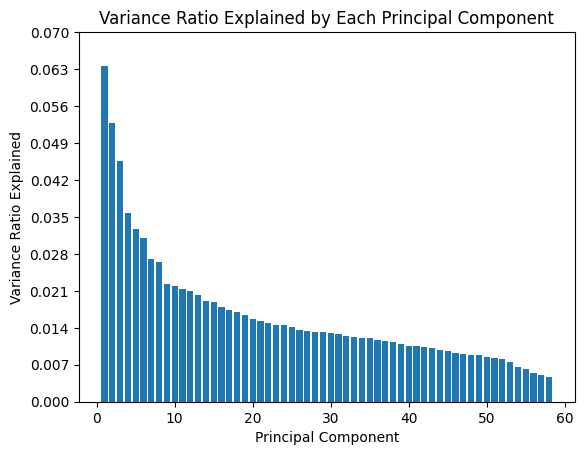

Number of components required to achieve 0.95 variance explained: 58
Epoch 1/20
200/200 [==============================] - 1s 1ms/step - loss: 0.3686 - accuracy: 0.8567
Epoch 2/20
200/200 [==============================] - 0s 1ms/step - loss: 0.3281 - accuracy: 0.8672
Epoch 3/20
200/200 [==============================] - 0s 1ms/step - loss: 0.3064 - accuracy: 0.8711
Epoch 4/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2966 - accuracy: 0.8744
Epoch 5/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2931 - accuracy: 0.8750
Epoch 6/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2846 - accuracy: 0.8839
Epoch 7/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2744 - accuracy: 0.8847
Epoch 8/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2711 - accuracy: 0.8916
Epoch 9/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2651 - accuracy: 0.8920
Epoch 10/20
200/200 [==========

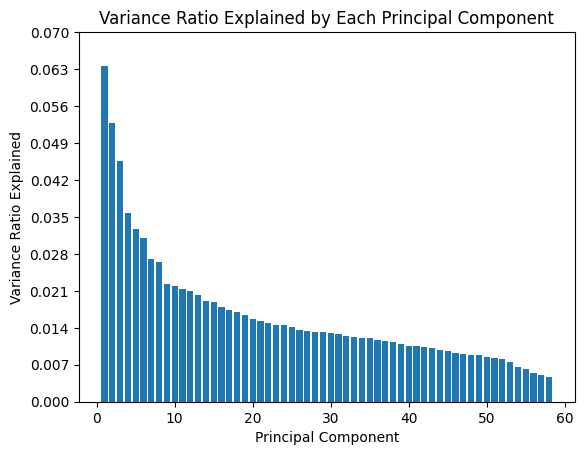

Number of components required to achieve 0.95 variance explained: 58
Epoch 1/20
200/200 [==============================] - 1s 1ms/step - loss: 0.3706 - accuracy: 0.8562
Epoch 2/20
200/200 [==============================] - 0s 1ms/step - loss: 0.3262 - accuracy: 0.8687
Epoch 3/20
200/200 [==============================] - 0s 1ms/step - loss: 0.3046 - accuracy: 0.8744
Epoch 4/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2929 - accuracy: 0.8784
Epoch 5/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2913 - accuracy: 0.8789
Epoch 6/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2801 - accuracy: 0.8803
Epoch 7/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2751 - accuracy: 0.8813
Epoch 8/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2684 - accuracy: 0.8855
Epoch 9/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2612 - accuracy: 0.8895
Epoch 10/20
200/200 [==========

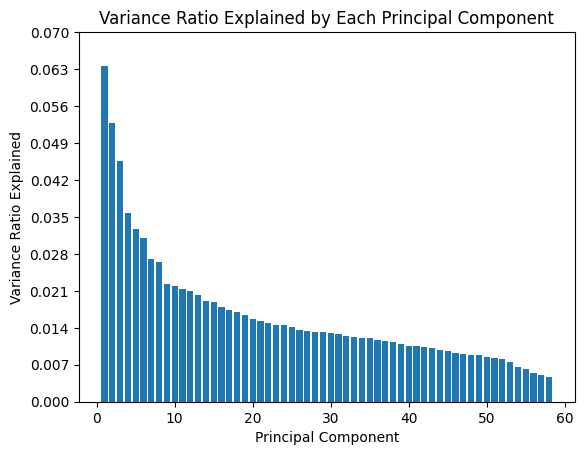

Number of components required to achieve 0.95 variance explained: 58
Epoch 1/20
200/200 [==============================] - 1s 1ms/step - loss: 0.3756 - accuracy: 0.8594
Epoch 2/20
200/200 [==============================] - 0s 1ms/step - loss: 0.3265 - accuracy: 0.8645
Epoch 3/20
200/200 [==============================] - 0s 1ms/step - loss: 0.3129 - accuracy: 0.8712
Epoch 4/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2940 - accuracy: 0.8763
Epoch 5/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2915 - accuracy: 0.8764
Epoch 6/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2817 - accuracy: 0.8847
Epoch 7/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2767 - accuracy: 0.8838
Epoch 8/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2738 - accuracy: 0.8858
Epoch 9/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2589 - accuracy: 0.8917
Epoch 10/20
200/200 [==========

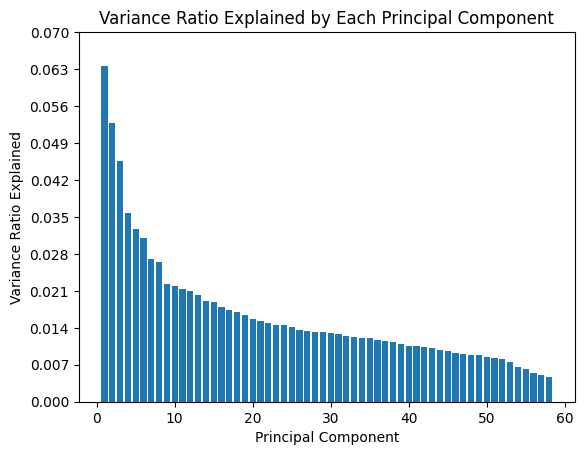

Number of components required to achieve 0.95 variance explained: 58
Epoch 1/20
200/200 [==============================] - 1s 1ms/step - loss: 0.3847 - accuracy: 0.8517
Epoch 2/20
200/200 [==============================] - 0s 1ms/step - loss: 0.3280 - accuracy: 0.8697
Epoch 3/20
200/200 [==============================] - 0s 1ms/step - loss: 0.3125 - accuracy: 0.8734
Epoch 4/20
200/200 [==============================] - 0s 1ms/step - loss: 0.3011 - accuracy: 0.8728
Epoch 5/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2916 - accuracy: 0.8788
Epoch 6/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2849 - accuracy: 0.8795
Epoch 7/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2775 - accuracy: 0.8819
Epoch 8/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2741 - accuracy: 0.8839
Epoch 9/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2653 - accuracy: 0.8850
Epoch 10/20
200/200 [==========

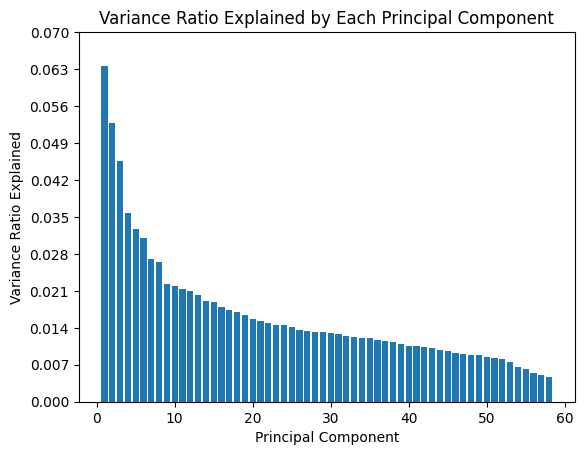

Number of components required to achieve 0.95 variance explained: 58
Epoch 1/20
200/200 [==============================] - 1s 1ms/step - loss: 0.3782 - accuracy: 0.8528
Epoch 2/20
200/200 [==============================] - 0s 1ms/step - loss: 0.3231 - accuracy: 0.8661
Epoch 3/20
200/200 [==============================] - 0s 1ms/step - loss: 0.3078 - accuracy: 0.8764
Epoch 4/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2963 - accuracy: 0.8777
Epoch 5/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2893 - accuracy: 0.8770
Epoch 6/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2850 - accuracy: 0.8825
Epoch 7/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2735 - accuracy: 0.8858
Epoch 8/20
200/200 [==============================] - 0s 1ms/step - loss: 0.2709 - accuracy: 0.8841
Epoch 9/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2652 - accuracy: 0.8894
Epoch 10/20
200/200 [==========

In [67]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(m1_df,NN_PCA_model)

In [68]:
print(f"basic_NN_PCA for m1_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
method_name = "PCA_m1_df"
df_results.loc[3] = [method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]

basic_NN_PCA for m1_df : mean_prec = 0.4909496959743816, mean_rec =  0.34279279279279284, stdev_prec = 0.027580029363618204, stdev_recall = 0.04919818087635031


**3.4 -Managing the inbalance problem.**

Balancing the initial dataframes with two different methods:

 - SOMTE
 - RandomOverSampler

In [69]:
def NN_Balanced_model(df, method):
    """
    Builds and trains an improved neural network model for binary classification with previous balanced strategy of the df.

    Args:
        Data frame.
        Method: balancing method to be applied to the Data frame

    Returns:
        Predicted value and real test value.
    """
    # Extract features and target variable
    X = df.drop(columns=['In-hospital_death', 'Length_of_stay', 'RecordID'])
    y = df['In-hospital_death']

    # Data splitting
    test_size = 0.2
    random_state = 42
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Data balancing
    met = method(random_state=42)
    X_train, y_train = met.fit_resample(X_train, y_train)

    # Data normalization
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Model architecture with BatchNormalization and Dropout
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))  # Add dropout layer
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer and compilation
    sgd = SGD(learning_rate=0.1)
    model.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy"])

    # Model training
    epochs = 20
    batch_size = 32
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    # Getting predictions
    y_pred = model.predict(X_test)
    y_pred_binary = np.where(y_pred > 0.5, 1, 0)

    # Calculate metrics
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    print(f"Precision on test set: {precision:.2f}")
    print(f"Recall on test set: {recall:.2f}")

    return  y_test,y_pred_binary

as now we are using a function (NN_Balanced_model) that requiers an extra argument from run_10_times function we must use a labmda function to be able to pass this extra argument.

In [70]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(knn_df, lambda method: NN_Balanced_model(knn_df, method=SMOTE))

Epoch 1/20
344/344 [==============================] - 1s 2ms/step - loss: 0.4956 - accuracy: 0.7629
Epoch 2/20
344/344 [==============================] - 0s 1ms/step - loss: 0.3928 - accuracy: 0.8260
Epoch 3/20
344/344 [==============================] - 0s 1ms/step - loss: 0.3535 - accuracy: 0.8506
Epoch 4/20
344/344 [==============================] - 0s 1ms/step - loss: 0.3335 - accuracy: 0.8592
Epoch 5/20
344/344 [==============================] - 0s 1ms/step - loss: 0.2985 - accuracy: 0.8761
Epoch 6/20
344/344 [==============================] - 0s 1ms/step - loss: 0.2868 - accuracy: 0.8780
Epoch 7/20
344/344 [==============================] - 1s 2ms/step - loss: 0.2704 - accuracy: 0.8906
Epoch 8/20
344/344 [==============================] - 1s 2ms/step - loss: 0.2506 - accuracy: 0.8982
Epoch 9/20
344/344 [==============================] - 1s 2ms/step - loss: 0.2393 - accuracy: 0.9023
Epoch 10/20
344/344 [==============================] - 1s 2ms/step - loss: 0.2311 - accuracy: 0.9063

In [71]:
print(f"basic_NN_smote for knn_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
method_name = "Smote_knn_df"
df_results.loc[4] = [method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]

basic_NN_smote for knn_df : mean_prec = 0.37108282926173697, mean_rec =  0.4436936936936937, stdev_prec = 0.01356539156311206, stdev_recall = 0.05853256526354766


In [72]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(m1_df, lambda method: NN_Balanced_model(m1_df, method=SMOTE))

Epoch 1/20
344/344 [==============================] - 1s 2ms/step - loss: 0.5121 - accuracy: 0.7507
Epoch 2/20
344/344 [==============================] - 1s 2ms/step - loss: 0.4197 - accuracy: 0.8095
Epoch 3/20
344/344 [==============================] - 1s 2ms/step - loss: 0.3795 - accuracy: 0.8319
Epoch 4/20
344/344 [==============================] - 1s 2ms/step - loss: 0.3590 - accuracy: 0.8431
Epoch 5/20
344/344 [==============================] - 1s 2ms/step - loss: 0.3315 - accuracy: 0.8625
Epoch 6/20
344/344 [==============================] - 1s 2ms/step - loss: 0.3174 - accuracy: 0.8663
Epoch 7/20
344/344 [==============================] - 1s 2ms/step - loss: 0.2987 - accuracy: 0.8749
Epoch 8/20
344/344 [==============================] - 1s 2ms/step - loss: 0.2811 - accuracy: 0.8831
Epoch 9/20
344/344 [==============================] - 1s 2ms/step - loss: 0.2732 - accuracy: 0.8876
Epoch 10/20
344/344 [==============================] - 1s 2ms/step - loss: 0.2543 - accuracy: 0.8934

In [73]:
print(f"basic_NN_smote for m1_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
method_name = "Smote_m1_df"
df_results.loc[5] = [method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]

basic_NN_smote for m1_df : mean_prec = 0.376281397438426, mean_rec =  0.472072072072072, stdev_prec = 0.025793538035865524, stdev_recall = 0.03458802490171616


In [74]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(knn_df, lambda method: NN_Balanced_model(knn_df, method=RandomOverSampler))

Epoch 1/20
344/344 [==============================] - 1s 2ms/step - loss: 0.5335 - accuracy: 0.7315
Epoch 2/20
344/344 [==============================] - 1s 1ms/step - loss: 0.4472 - accuracy: 0.7920
Epoch 3/20
344/344 [==============================] - 0s 1ms/step - loss: 0.4044 - accuracy: 0.8149
Epoch 4/20
344/344 [==============================] - 0s 1ms/step - loss: 0.3671 - accuracy: 0.8415
Epoch 5/20
344/344 [==============================] - 0s 1ms/step - loss: 0.3319 - accuracy: 0.8575
Epoch 6/20
344/344 [==============================] - 1s 2ms/step - loss: 0.3080 - accuracy: 0.8694
Epoch 7/20
344/344 [==============================] - 1s 2ms/step - loss: 0.2987 - accuracy: 0.8751
Epoch 8/20
344/344 [==============================] - 1s 2ms/step - loss: 0.2747 - accuracy: 0.8879
Epoch 9/20
344/344 [==============================] - 1s 2ms/step - loss: 0.2626 - accuracy: 0.8909
Epoch 10/20
344/344 [==============================] - 1s 2ms/step - loss: 0.2538 - accuracy: 0.8931

In [75]:
print(f"basic_NN_ros for knn_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
method_name = "ros_knn_df"
df_results.loc[6] = [method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]

basic_NN_ros for knn_df : mean_prec = 0.38529771049373224, mean_rec =  0.509009009009009, stdev_prec = 0.022549419165285165, stdev_recall = 0.04864030625835347


In [76]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(m1_df, lambda method: NN_Balanced_model(m1_df, method=RandomOverSampler))

Epoch 1/20
344/344 [==============================] - 1s 1ms/step - loss: 0.5473 - accuracy: 0.7229
Epoch 2/20
344/344 [==============================] - 1s 2ms/step - loss: 0.4627 - accuracy: 0.7846
Epoch 3/20
344/344 [==============================] - 1s 2ms/step - loss: 0.4271 - accuracy: 0.8086
Epoch 4/20
344/344 [==============================] - 0s 1ms/step - loss: 0.3916 - accuracy: 0.8265
Epoch 5/20
344/344 [==============================] - 0s 1ms/step - loss: 0.3693 - accuracy: 0.8421
Epoch 6/20
344/344 [==============================] - 0s 1ms/step - loss: 0.3396 - accuracy: 0.8506
Epoch 7/20
344/344 [==============================] - 0s 1ms/step - loss: 0.3310 - accuracy: 0.8593
Epoch 8/20
344/344 [==============================] - 0s 1ms/step - loss: 0.3084 - accuracy: 0.8681
Epoch 9/20
344/344 [==============================] - 0s 1ms/step - loss: 0.2969 - accuracy: 0.8760
Epoch 10/20
344/344 [==============================] - 1s 2ms/step - loss: 0.2823 - accuracy: 0.8822

In [77]:
print(f"basic_NN_ros for m1_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
method_name = "ros_m1_df"
df_results.loc[7] = [method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]

basic_NN_ros for m1_df : mean_prec = 0.3872417312770608, mean_rec =  0.5220720720720722, stdev_prec = 0.0165354555333689, stdev_recall = 0.04332059523215909


In [81]:
df_results_8000= df_results
df_results_8000['Model'] = 'NN'
df_results_8000 = df_results_8000[['Model'] + [col for col in df_results_8000.columns if col != 'Model']]

In [82]:
df_results_8000

,Model,Method,mean_precision,mean_recall,stdev_precision,stdev_recall
0,NN,knn_df,0.461086,0.363063,0.037441,0.051682
1,NN,m1_df,0.469030,0.355405,0.032352,0.042469
2,NN,PCA_knn_df,0.480290,0.327477,0.043735,0.064276
3,NN,PCA_m1_df,0.490950,0.342793,0.027580,0.049198
4,NN,Smote_knn_df,0.371083,0.443694,0.013565,0.058533
5,NN,Smote_m1_df,0.376281,0.472072,0.025794,0.034588
6,NN,ros_knn_df,0.385298,0.509009,0.022549,0.048640
7,NN,ros_m1_df,0.387242,0.522072,0.016535,0.043321
